In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog
import matplotlib.patches as mpatches
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

Wild Type(AD6-D2),
AH1-KO (Tube),
AH-KO(LIGHTS OFF),
/Users/kaycei/K on Server (NoMachine)/KayCei/HDC/AH1-KO/OCD Bouts
Animal              Wild Type(AD6-D2),  AH-KO(LIGHTS OFF),  AH1-KO (Tube),
Keys                                                                      
Locomotion                      1492.0              4143.0          5394.0
Investigate Type 1                12.0               505.0           250.0
Investigate Type 2              2086.0              4497.0          4812.0
Investigate Type 3               242.0               281.0           147.0
Dive/Scrunch                     160.0               278.0           154.0
Contra-Orient                    853.0              1710.0          1802.0
Ipsi-Orient                      974.0              2053.0          1658.0
Face Groom Type 1                380.0               183.0           101.0
Face Groom Type 2                  NaN                 3.0             4.0
Rear                             315.0               335

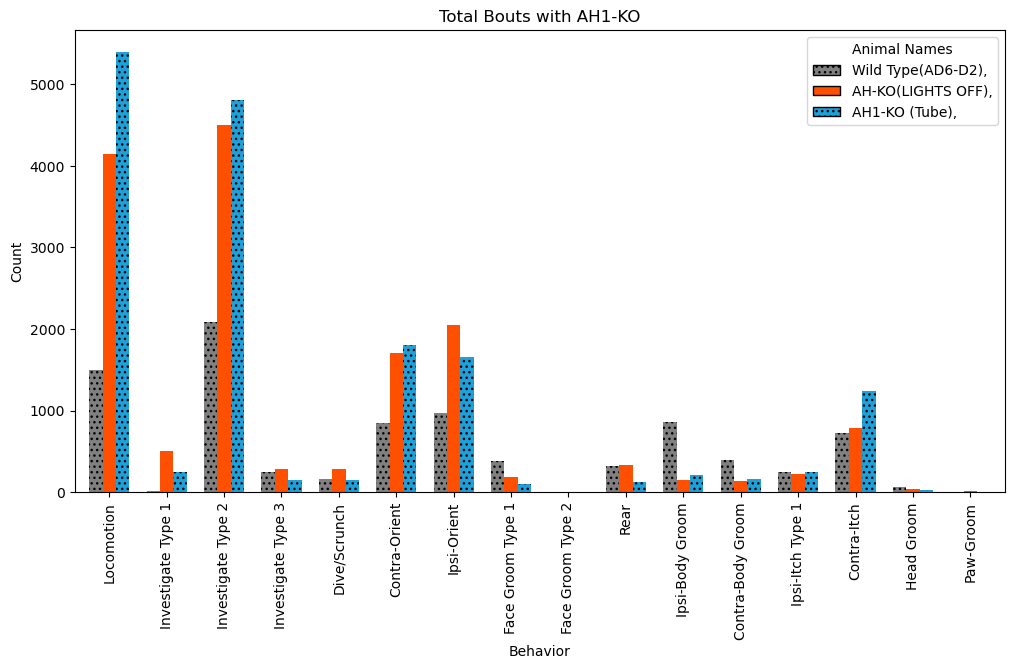

In [30]:
# Define the function to parse the CSV file
def parse_csv(filename):
    data = {}
    animal_name = ""

    with open(filename, newline='') as csvfile:
        first_line = csvfile.readline()
        animal_name = first_line.strip() 
        print(animal_name)
    reader = pd.read_csv(filename, skiprows=1)
    for index, row in reader.iterrows():
        if animal_name:
            key = row.iloc[0]
            value = float(row.iloc[1])
            data[animal_name] = data.get(animal_name, {})
            data[animal_name][key] = value

    return data

root = tk.Tk()
root.withdraw()

file_paths = filedialog.askopenfilenames(
    title="Select CSV Files",
    filetypes=[("CSV Files", "*.csv")]
)

if not file_paths:
    print("No CSV files selected.")
else:
    keys = []
    values = []
    colors = []

    for file_path in file_paths:
        file_data = parse_csv(file_path)
        for animal, data in file_data.items():
            if 'insignificant' in data:
                del data['insignificant']  # Remove the 'Insignificant' key and its data
            for key, value in data.items():
                keys.append(key)
                values.append(value)
                colors.append(animal)
    parts = file_paths[0].split('/')
    #print(parts)
    directory_path = '/'.join(parts[:-1])  # Join all parts except the last two
    print(directory_path)
    df = pd.DataFrame({'Keys': keys, 'Values': values, 'Animal': colors})

    # Filter out the 'Insignificant' key and its data from the DataFrame
    df = df[df['Keys'] != 'insignificant']
    
    # Reorder the DataFrame by the desired animal order and index order
    animal_order = ['Wild Type(AD6-D2),','AH-KO(LIGHTS OFF),','AH1-KO (Tube),']
    key_order = ['Locomotion', 'Investigate Type 1','Investigate Type 2', 'Investigate Type 3',
                 'Dive/Scrunch', 'Contra-Orient','Ipsi-Orient','Face Groom Type 1',
                 'Face Groom Type 2', 'Rear','Ipsi-Body Groom','Contra-Body Groom', 'Ipsi-Itch Type 1',
                 'Contra-Itch', 'Head Groom', 'Paw-Groom'
                ] # Get the unique keys in the order they appear in the DataFrame
    
    pivot_df = df.pivot(index='Keys', columns='Animal', values='Values')

    # Reorder columns based on animal_order
    pivot_df = pivot_df[animal_order]

    # Reorder rows based on key_order
    pivot_df = pivot_df.reindex(key_order)
    
    # Define colors for AH1, AH2, AH3, and AH4
    colors = {'AH-KO(LIGHTS OFF),': '#ff4f00', 'AH1-KO (Tube),': '#20a0d9'}
    
    ax = pivot_df.plot(kind='bar', figsize=(12, 6), color=[colors.get(col, 'gray') for col in pivot_df.columns], width=0.7)
    
    folders = (os.path.dirname(file_path)).split('/')
    fol5 = folders[5].split(' ')  # Split element at position 3 by hyphen
    fol6 = folders[6]  
    
    # You want to count skip every 16 which is one animal because hatching identifies the animal. 
    # This ensures there is one animal per group with hatching 
    step = 16  # Step size: The number of behaviors for each animal
    counter = 0  # Counter to keep track of the current position
    bars_to_hatch = []
    while counter < len(ax.patches):
        bars_to_hatch.extend(ax.patches[counter:counter+step])
        counter += step * 2

    for i, bar in enumerate(bars_to_hatch):
        if i < 16:
            bar.set_hatch('...')  # Apply '***' hatch pattern to the first 16 bars
        else:
            bar.set_hatch('...')  # Apply '///' hatch pattern to the next 16 bars
    

    plt.title(f'Total Bouts with {fol6}')
    plt.xlabel('Behavior')
    plt.ylabel('Count')
    # Print the table
    print(pivot_df)

    # Create a legend with labels and hatching patterns
    legend_handles = []
    
    for i, animal in enumerate(animal_order):
        # Determine the hatch pattern based on the index
        hatch = '...' if i % 2 == 0 else ''
            
        # Create a colored patch with a label and custom hatch pattern
        color_patch = mpatches.Patch(facecolor=colors.get(animal, 'gray'), edgecolor='black', label=animal, hatch=hatch)

        # Append the color patch to the legend_handles list
        legend_handles.append(color_patch)

    # Add a legend to the plot, specifying the custom legend handles
    plt.legend(handles=legend_handles, title='Animal Names')

    # Set the file path where you want to save the plot
    save_path = os.path.join(directory_path, 'Combined Total Bouts Plot.png')  # You can specify the file format (e.g., 'plot.png')

    # Save the plot to the specified file path
    plt.savefig(save_path)

    # Display the plot (optional)
    plt.show()

# Close the plot
plt.close()


In [21]:
print(pivot_df.columns)



Index(['Wild Type(AD6-D2),', 'AH-KO(LIGHTS OFF),', 'AH1-KO (Tube),'], dtype='object', name='Animal')


In [22]:
import scipy.stats as stats

# Define the significance level
alpha = 0.05

# Create a dictionary to store t-test results for each behavior
t_test_results = {}

# Loop through the behaviors in key_order
for behavior in key_order:
    # Select the data for each animal for the current behavior
    behavior_data = {animal: df[(df['Animal'] == animal) & (df['Keys'] == behavior)]['Values'] for animal in animal_order}
    
    # Remove rows with NaN values
    behavior_data_cleaned = {animal: data.dropna() for animal, data in behavior_data.items()}
    
    # Perform t-tests for all pairs of animals for the current behavior
    t_test_results[behavior] = {}
    for i in range(len(animal_order)):
        for j in range(i+1, len(animal_order)):
            animal1 = animal_order[i]
            animal2 = animal_order[j]
            
            # Perform the t-test on cleaned data
            t_statistic, p_value = stats.ttest_ind(behavior_data_cleaned[animal1], behavior_data_cleaned[animal2])
            
            # Store the results in the dictionary
            t_test_results[behavior][(animal1, animal2)] = {
                'T-Statistic': t_statistic,
                'P-Value': p_value,
                'Significant': p_value < alpha
            }

# Print the t-test results
for behavior, results in t_test_results.items():
    print(f'Behavior: {behavior}')
    for animals, data in results.items():
        animal1, animal2 = animals
        print(f'{animal1} vs. {animal2}:')
        print(f'T-Statistic: {data["T-Statistic"]}')
        print(f'P-Value: {data["P-Value"]}')
        if data['Significant']:
            print('The difference is statistically significant (reject the null hypothesis)')
        else:
            print('The difference is not statistically significant (fail to reject the null hypothesis)')
    print()


Behavior: Locomotion
Wild Type(AD6-D2), vs. AH-KO(LIGHTS OFF),:
T-Statistic: nan
P-Value: nan
The difference is not statistically significant (fail to reject the null hypothesis)
Wild Type(AD6-D2), vs. AH1-KO (Tube),:
T-Statistic: nan
P-Value: nan
The difference is not statistically significant (fail to reject the null hypothesis)
AH-KO(LIGHTS OFF), vs. AH1-KO (Tube),:
T-Statistic: nan
P-Value: nan
The difference is not statistically significant (fail to reject the null hypothesis)

Behavior: Investigate Type 1
Wild Type(AD6-D2), vs. AH-KO(LIGHTS OFF),:
T-Statistic: nan
P-Value: nan
The difference is not statistically significant (fail to reject the null hypothesis)
Wild Type(AD6-D2), vs. AH1-KO (Tube),:
T-Statistic: nan
P-Value: nan
The difference is not statistically significant (fail to reject the null hypothesis)
AH-KO(LIGHTS OFF), vs. AH1-KO (Tube),:
T-Statistic: nan
P-Value: nan
The difference is not statistically significant (fail to reject the null hypothesis)

Behavior: Invest

/Users/kaycei/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:7030: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df


Wild Type(AD6-D2),
AH1-KO(Tube),
AH1-KO(LIGHTS OFF),
/Users/kaycei/K on Server (NoMachine)/KayCei/HDC/AH1-KO/OCD Duration
Animal              Wild Type(AD6-D2),  AH1-KO(LIGHTS OFF),  AH1-KO(Tube),
Keys                                                                      
Locomotion                       0.234                0.325          0.288
Investigate Type 1               0.142                0.241          0.256
Investigate Type 2               0.497                0.278          0.252
Investigate Type 3               0.255                0.210          0.178
Dive/Scrunch                     0.118                0.123          0.114
Contra-Orient                    0.119                0.127          0.114
Ipsi-Orient                      0.136                0.137          0.118
Face Groom Type 1                0.189                0.187          0.172
Face Groom Type 2                  NaN                0.133          0.100
Rear                             0.230               

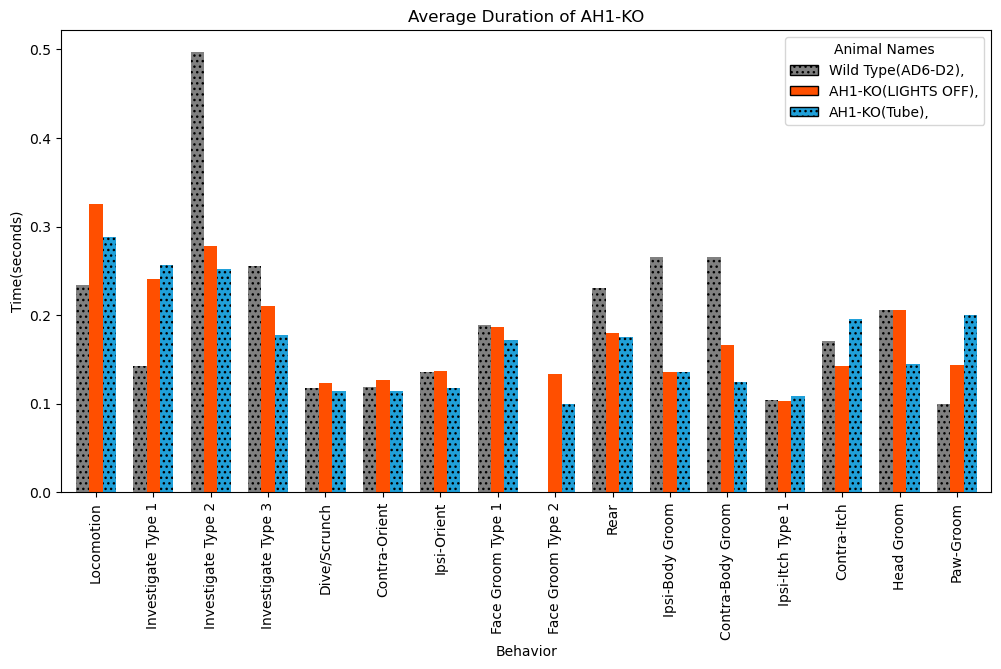

In [31]:
# Define the function to parse the CSV file
def parse_csv(filename):
    data = {}
    animal_name = ""

    with open(filename, newline='') as csvfile:
        first_line = csvfile.readline()
        animal_name = first_line.strip() 
        print(animal_name)
    reader = pd.read_csv(filename, skiprows=1)
    for index, row in reader.iterrows():
        if animal_name:
            key = row.iloc[0]
            value = float(row.iloc[1])
            data[animal_name] = data.get(animal_name, {})
            data[animal_name][key] = value

    return data

root = tk.Tk()
root.withdraw()

file_paths = filedialog.askopenfilenames(
    title="Select CSV Files",
    filetypes=[("CSV Files", "*.csv")]
)

if not file_paths:
    print("No CSV files selected.")
else:
    keys = []
    values = []
    colors = []

    for file_path in file_paths:
        file_data = parse_csv(file_path)
        for animal, data in file_data.items():
            if 'insignificant' in data:
                del data['insignificant']  # Remove the 'Insignificant' key and its data
            for key, value in data.items():
                keys.append(key)
                values.append(value)
                colors.append(animal)
    parts = file_paths[0].split('/')
    #print(parts)
    directory_path = '/'.join(parts[:-1])  # Join all parts except the last two
    print(directory_path)
    df = pd.DataFrame({'Keys': keys, 'Values': values, 'Animal': colors})

    # Filter out the 'Insignificant' key and its data from the DataFrame
    df = df[df['Keys'] != 'insignificant']
    
    # Reorder the DataFrame by the desired animal order and index order
    animal_order = ['Wild Type(AD6-D2),','AH1-KO(LIGHTS OFF),','AH1-KO(Tube),']
    key_order = ['Locomotion', 'Investigate Type 1','Investigate Type 2', 'Investigate Type 3',
                 'Dive/Scrunch', 'Contra-Orient','Ipsi-Orient','Face Groom Type 1',
                 'Face Groom Type 2', 'Rear','Ipsi-Body Groom','Contra-Body Groom', 'Ipsi-Itch Type 1',
                 'Contra-Itch', 'Head Groom', 'Paw-Groom'
                ] # Get the unique keys in the order they appear in the DataFrame
    
    pivot_df = df.pivot(index='Keys', columns='Animal', values='Values')

    # Reorder columns based on animal_order
    pivot_df = pivot_df[animal_order]

    # Reorder rows based on key_order
    pivot_df = pivot_df.reindex(key_order)
    
    # Define colors for AH1, AH2, AH3, and AH4
    colors = {'AH1-KO(LIGHTS OFF),': '#ff4f00', 'AH1-KO(Tube),': '#20a0d9'}
    
    ax = pivot_df.plot(kind='bar', figsize=(12, 6), color=[colors.get(col, 'gray') for col in pivot_df.columns], width=0.7)
    
    folders = (os.path.dirname(file_path)).split('/')
    fol5 = folders[5].split(' ')  # Split element at position 3 by hyphen
    fol6 = folders[6]  
    
    # You want to count skip every 16 which is one animal because hatching identifies the animal. 
    # This ensures there is one animal per group with hatching 
    step = 16  # Step size: The number of behaviors for each animal
    counter = 0  # Counter to keep track of the current position
    bars_to_hatch = []
    while counter < len(ax.patches):
        bars_to_hatch.extend(ax.patches[counter:counter+step])
        counter += step * 2

    for i, bar in enumerate(bars_to_hatch):
        if i < 16:
            bar.set_hatch('...')  # Apply '***' hatch pattern to the first 16 bars
        else:
            bar.set_hatch('...')  # Apply '///' hatch pattern to the next 16 bars
    

    plt.title(f'Average Duration of {fol6}')
    plt.xlabel('Behavior')
    plt.ylabel('Time(seconds)')
    # Print the table
    print(pivot_df)

    # Create a legend with labels and hatching patterns
    legend_handles = []
    
    for i, animal in enumerate(animal_order):
        # Determine the hatch pattern based on the index
        hatch = '...' if i % 2 == 0 else ''
            
        # Create a colored patch with a label and custom hatch pattern
        color_patch = mpatches.Patch(facecolor=colors.get(animal, 'gray'), edgecolor='black', label=animal, hatch=hatch)

        # Append the color patch to the legend_handles list
        legend_handles.append(color_patch)

    # Add a legend to the plot, specifying the custom legend handles
    plt.legend(handles=legend_handles, title='Animal Names')

    # Set the file path where you want to save the plot
    save_path = os.path.join(directory_path, 'Combined Average Duration Plot.png')  # You can specify the file format (e.g., 'plot.png')

    # Save the plot to the specified file path
    plt.savefig(save_path)

    # Display the plot (optional)
    plt.show()

# Close the plot
plt.close()

In [4]:
print(pivot_df.columns)


Index(['AH-KO- Tube', 'AH1 LIGHTS OFF,'], dtype='object', name='Animal')


In [16]:
print(file_paths[0])
parts = file_paths[0].split('/')
print(parts)
directory_path = '/'.join(parts[:-1])  # Join all parts except the last two
print(directory_path)

/Users/kaycei/K on Server (NoMachine)/KayCei/HDC/AH1-KO/OCD Duration/AD6-D2-Duration data.csv
['', 'Users', 'kaycei', 'K on Server (NoMachine)', 'KayCei', 'HDC', 'AH1-KO', 'OCD Duration', 'AD6-D2-Duration data.csv']
/Users/kaycei/K on Server (NoMachine)/KayCei/HDC/AH1-KO/OCD Duration
